# Final Processing
The final processing stage requires:
1. Quick validation of catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue

In [1]:
import seaborn as sns
from astropy.table import Table,  join
%matplotlib inline
import numpy as np
import pylab as plt

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Read tables

In [2]:
cat=Table.read('./data/dmu26_XID+SPIRE_GAMA-12_cat.fits')
from astropy import units as u
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [3]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J121422.583-031337.382,183.59409564078072,-3.2270505731570296,0.35461372,0.74793154,0.11122021,0.46891683,0.84328055,0.16682458,0.5681405,1.0451108,0.19659372,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,0.9996342,1.0011587,1.0030327,2435.1606,2046.318,2401.8926,0.0,0.0,0.0
HELP_J121424.663-031430.619,183.60276393306515,-3.24183857808384,0.36688107,0.7239106,0.12602691,0.44334495,0.81703377,0.13582505,0.6003845,1.0408075,0.21559626,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,0.9988918,0.9998199,0.99883676,2219.9006,2101.7231,2243.482,0.0,0.0,0.0
HELP_J121425.213-031343.292,183.60505319233567,-3.2286921716514594,0.28403008,0.5910051,0.07379482,0.25953385,0.58475494,0.063190006,0.2790112,0.6115537,0.07534172,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,0.999747,1.0001712,0.99878854,2148.0793,2278.384,2477.7153,0.0,0.0,0.0
HELP_J121425.282-031317.908,183.60534205341955,-3.221641108104603,0.3495887,0.7213653,0.1017157,0.3344644,0.6833062,0.1058634,0.32436097,0.69109875,0.09584675,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,0.9995672,0.99937844,0.99871916,2890.743,2756.0068,2381.0923,0.0,0.0,0.0
HELP_J121425.730-031349.333,183.60720659082364,-3.230370294805069,0.27679932,0.608078,0.0776306,0.2918203,0.6320284,0.07645259,0.3194455,0.66039824,0.08941861,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,1.0003843,0.9991781,0.9989462,2264.0225,2399.0828,2663.4702,0.0,0.0,0.0
HELP_J121427.153-031319.999,183.61313770407818,-3.2222219390213924,0.36854535,0.70392716,0.11451078,0.38260907,0.7435305,0.11936445,0.40914872,0.79278386,0.13954079,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,1.0022343,0.9993207,0.998882,1974.2902,2276.129,2226.8752,0.0,0.0,0.0
HELP_J121430.165-031405.236,183.62568828279663,-3.234787865042926,0.34237245,0.6890011,0.1160518,0.34197137,0.6992016,0.09984689,0.43466145,0.8577948,0.13478038,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,0.9989757,0.99910563,1.0000625,2891.8792,2095.5903,2281.6455,0.0,0.0,0.0
HELP_J121431.395-031423.988,183.63081297737267,-3.239996804538412,0.30229762,0.678159,0.092441775,0.2951933,0.62302965,0.0725232,0.2733159,0.61645436,0.076226465,-0.085924305,-0.16274032,-0.3615025,0.01724542,0.023768738,0.035566796,1.0006735,0.99999285,0.99955714,2592.6753,2844.944,2073.334,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

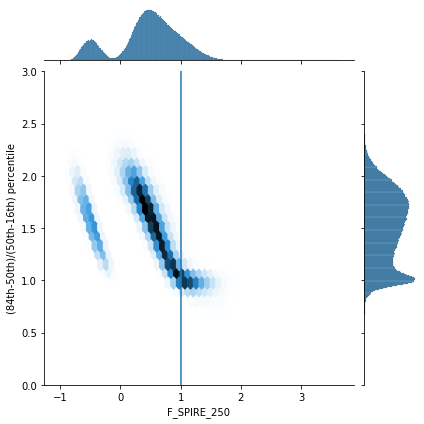

In [19]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])

ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex',ylim=(0,3))
g.ax_joint.axvline(x=np.log10(10))


For 250 $\mathrm{\mu m}$ depth is ~ 10mJy

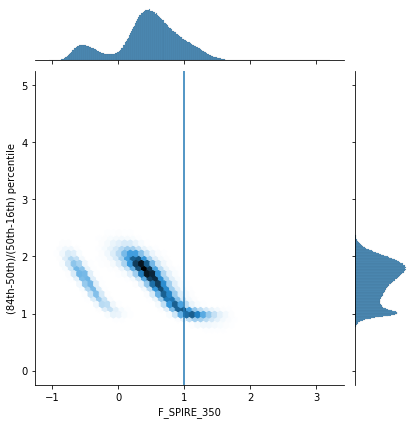

In [21]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(10))

For 350 $\mathrm{\mu m}$ depth is ~ 10mJy

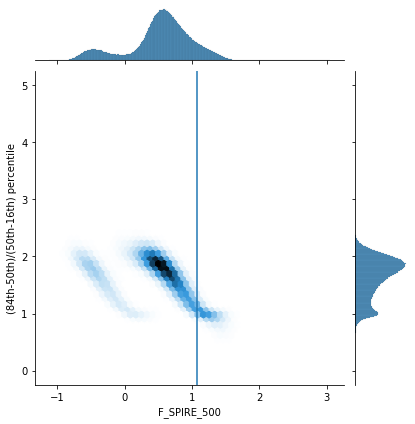

In [24]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
ind=skew>5
skew[ind]=np.nan
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')
g.ax_joint.axvline(x=np.log10(12))

For 500 $\mathrm{\mu m}$ depth is ~ 12mJy

## Add flag to catalogue

In [25]:
from astropy.table import Column
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [26]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 10)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 10)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 12)

In [27]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

1152878 1178422 1201914 1337864


In [28]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [29]:
cat.write('./data/dmu26_XID+SPIRE_GAMA-12_20201228.fits', format='fits',overwrite=True)

## Compare catalogue with old version

In [30]:
old_cat=Table.read('./data/dmu26_XID+SPIRE_GAMA_12_20180508.fits')

In [31]:

comparison=join(cat, old_cat, join_type='left', keys='HELP_ID')


In [32]:
comparison[0:5]

HELP_ID,RA_1,Dec_1,F_SPIRE_250_1,FErr_SPIRE_250_u_1,FErr_SPIRE_250_l_1,F_SPIRE_350_1,FErr_SPIRE_350_u_1,FErr_SPIRE_350_l_1,F_SPIRE_500_1,FErr_SPIRE_500_u_1,FErr_SPIRE_500_l_1,Bkg_SPIRE_250_1,Bkg_SPIRE_350_1,Bkg_SPIRE_500_1,Sig_conf_SPIRE_250_1,Sig_conf_SPIRE_350_1,Sig_conf_SPIRE_500_1,Rhat_SPIRE_250_1,Rhat_SPIRE_350_1,Rhat_SPIRE_500_1,n_eff_SPIRE_250_1,n_eff_SPIRE_500_1,n_eff_SPIRE_350_1,Pval_res_250_1,Pval_res_350_1,Pval_res_500_1,flag_spire_250_1,flag_spire_350_1,flag_spire_500_1,RA_2,Dec_2,F_SPIRE_250_2,FErr_SPIRE_250_u_2,FErr_SPIRE_250_l_2,F_SPIRE_350_2,FErr_SPIRE_350_u_2,FErr_SPIRE_350_l_2,F_SPIRE_500_2,FErr_SPIRE_500_u_2,FErr_SPIRE_500_l_2,Bkg_SPIRE_250_2,Bkg_SPIRE_350_2,Bkg_SPIRE_500_2,Sig_conf_SPIRE_250_2,Sig_conf_SPIRE_350_2,Sig_conf_SPIRE_500_2,Rhat_SPIRE_250_2,Rhat_SPIRE_350_2,Rhat_SPIRE_500_2,n_eff_SPIRE_250_2,n_eff_SPIRE_500_2,n_eff_SPIRE_350_2,Pval_res_250_2,Pval_res_350_2,Pval_res_500_2,flag_spire_250_2,flag_spire_350_2,flag_spire_500_2
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,bool
HELP_J112916.236+004455.105,172.31765184209056,0.7486403137874773,0.6079334,1.1508443,0.22279705,0.719259,1.2771379,0.25685567,0.91352665,1.5982244,0.34755203,-0.2890086,-0.5873606,-1.6379163,0.009524433,0.01250791,0.02171398,1.003183,0.9984325,1.0006536,2038.1409,2183.997,2177.9895,0.0,0.0,0.0,True,True,True,172.31765184209056,0.7486403137874773,4.306683,7.620201,1.4402963,4.586349,7.726623,1.6055241,4.664652,7.9181805,1.6829356,-1.9408696,-3.6604543,-8.53561,0.07947837,0.10366236,0.17167197,0.9986437,0.9987456,0.9987522,2000.0,2000.0,2000.0,0.0,0.0,0.0,False,True,True
HELP_J112916.735+004525.955,172.31972959942718,0.7572096649057047,0.29907072,0.6979346,0.08316563,0.29326132,0.6356679,0.08289944,0.3624976,0.86621684,0.10658185,-0.2890086,-0.5873606,-1.6379163,0.009524433,0.01250791,0.02171398,0.9998846,1.0012054,0.9996991,2315.588,2171.5947,1774.2477,0.0,0.0,0.0,True,True,True,172.31972959942718,0.7572096649057047,3.7273252,7.1019673,1.1449401,3.58954,6.746282,1.254194,4.0810566,7.7552614,1.2665064,-1.9408696,-3.6604543,-8.53561,0.07947837,0.10366236,0.17167197,0.99901325,0.99837273,0.99857515,2000.0,2000.0,2000.0,0.0,0.0,0.0,True,True,True
HELP_J112916.868+004538.834,172.32028336523268,0.7607873292267642,0.29733092,0.64382744,0.08452112,0.3566889,0.76987123,0.10695568,0.6896423,1.3246547,0.22260496,-0.2890086,-0.5873606,-1.6379163,0.009524433,0.01250791,0.02171398,1.0000952,0.9989561,1.0007457,2202.249,1768.9456,2262.899,0.0,0.0,0.0,True,True,True,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
HELP_J112916.993+004528.665,172.3208057566738,0.7579623882333963,0.21612749,0.5173419,0.055245437,0.23662432,0.5786439,0.06330738,0.35128444,0.82981384,0.0963407,-0.2890086,-0.5873606,-1.6379163,0.009524433,0.01250791,0.02171398,1.0013907,0.9986041,0.9989965,1743.9092,1917.8733,2237.7832,0.0,0.0,0.0,True,True,True,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
HELP_J112917.687+004454.217,172.32369623700535,0.7483935440762677,0.29553184,0.6497594,0.08786848,0.28174806,0.6306869,0.07677943,0.30611157,0.7198121,0.07412824,-0.2890086,-0.5873606,-1.6379163,0.009524433,0.01250791,0.02171398,1.0010365,1.0030154,0.9995577,1834.3885,2038.0673,1406.494,0.0,0.0,0.0,True,True,True,172.32369623700535,0.7483935440762677,3.4881992,6.5816007,1.1468914,3.4694955,6

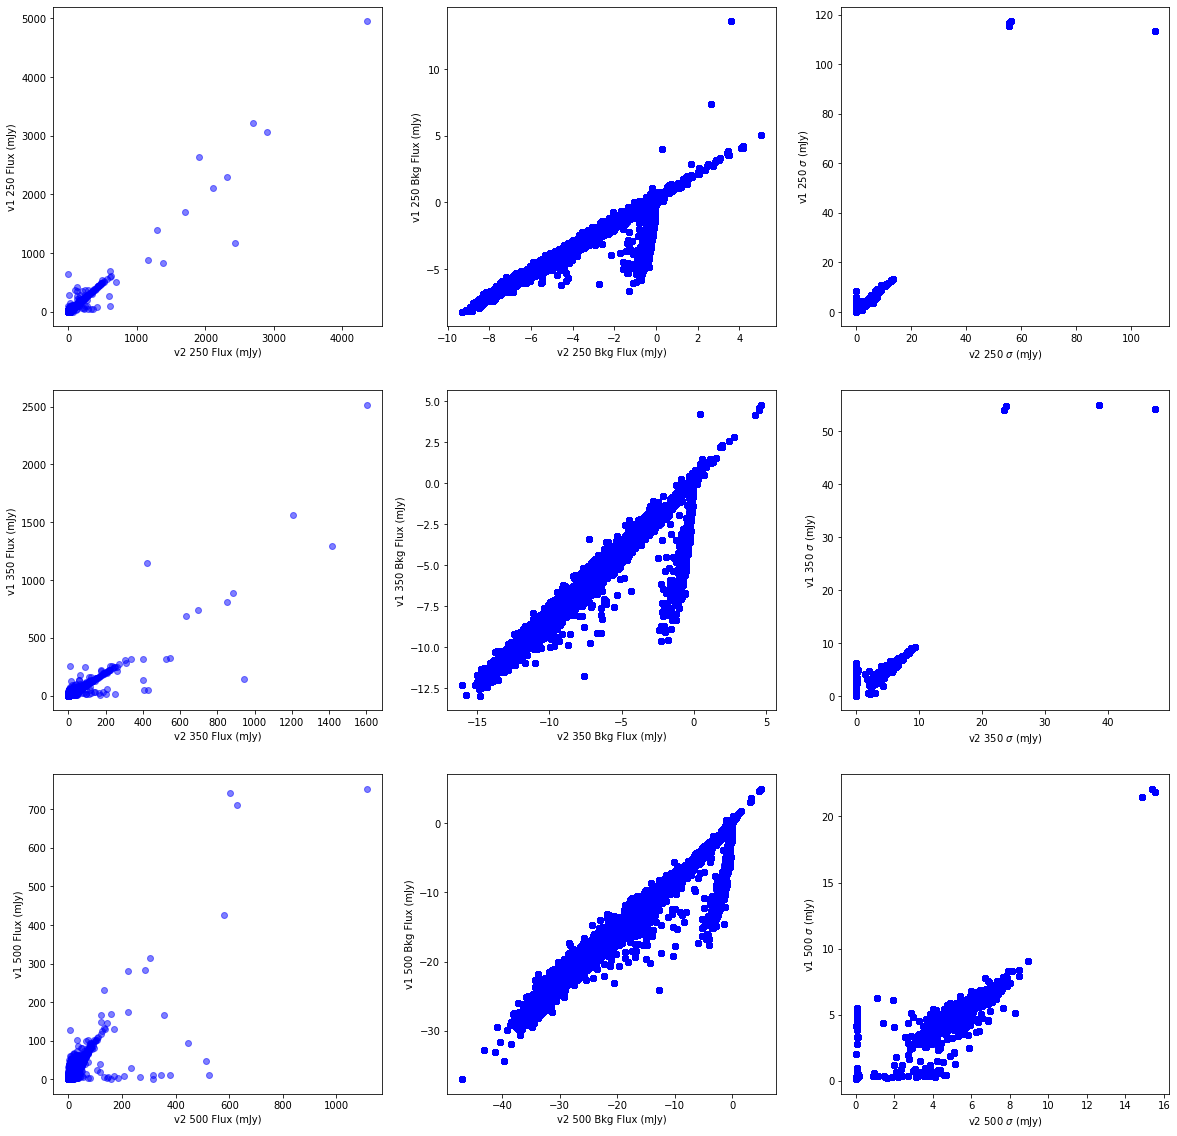

In [33]:
bands=[250,350,500]

fig,axes=plt.subplots(3,3,figsize=(20,20))
for i,b in enumerate(bands):
    axes[i,0].plot(comparison['F_SPIRE_{}_1'.format(b)],comparison['F_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,1].plot(comparison['Bkg_SPIRE_{}_1'.format(b)],comparison['Bkg_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    axes[i,2].plot(comparison['Sig_conf_SPIRE_{}_1'.format(b)],comparison['Sig_conf_SPIRE_{}_2'.format(b)],'bo',alpha=0.5)
    
    axes[i,0].set_xlabel('v2 {} Flux (mJy)'.format(b))
    axes[i,0].set_ylabel('v1 {} Flux (mJy)'.format(b))
    
    axes[i,1].set_xlabel('v2 {} Bkg Flux (mJy)'.format(b))
    axes[i,1].set_ylabel('v1 {} Bkg Flux (mJy)'.format(b))
    
    axes[i,2].set_xlabel('v2 {} $\sigma$ (mJy)'.format(b))
    axes[i,2].set_ylabel('v1 {} $\sigma$ (mJy)'.format(b))

All looks good.